<a href="https://colab.research.google.com/github/zznadazz/Interpolation/blob/main/Morphological_Interpolation_ITS3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Slice Interpolation for Medical Image based on Morphological Median


## Import libraries

In [ ]:
# Montez le lecteur Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from skimage.morphology import dilation, erosion, disk, square
from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize
from skimage.util import img_as_ubyte, img_as_float
from skimage.metrics import structural_similarity
from skimage.metrics import mean_squared_error

import nibabel as nib

## Display Results

In [ ]:
class MediaPlayer:

    @staticmethod
    def display_images(images, titles=None, x_labels=None, suptitle=None, cmap='gray'):
        """
        Affiche une séquence d'images avec des titres et des étiquettes d'axe X optionnels.

        :param images: Liste des images à afficher.
        :param titles: Liste des titres pour chaque image. Si None, pas de titres affichés.
        :param x_labels: Liste des étiquettes d'axe X pour chaque image. Si None, pas d'étiquettes affichées.
        :param cmap: Carte des couleurs à utiliser pour l'affichage des images.
        """
        num_images = len(images)
        if titles is None:
            titles = [''] * num_images  # Créer une liste vide de titres si aucun n'est fourni
        if x_labels is None:
            x_labels = [''] * num_images  # Créer une liste vide d'étiquettes d'axe X si aucun n'est fourni
        assert len(titles) == num_images, "Le nombre d'images doit correspondre au nombre de titres."
        assert len(x_labels) == num_images, "Le nombre d'images doit correspondre au nombre d'étiquettes d'axe X."

        plt.figure(figsize=(num_images * 4, 4))  # Ajuster la taille de la figure en fonction du nombre d'images
        plt.suptitle(suptitle, fontsize=16)
        for i, (image, title, x_label) in enumerate(zip(images, titles, x_labels)):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(image, cmap=cmap)
            plt.title(title)
            ax.set_xlabel(x_label)  # Définir l'étiquette d'axe X
            #plt.axis('off')
        plt.tight_layout()
        plt.show()


    @staticmethod
    def display_slides_with_step(slices, step=15):
        """
        Affiche les images avec un step spécifié.
        """
        images_test = {i: slices[i] for i in range(0, len(slices), step)}
        MediaPlayer.display_images(list(images_test.values()), titles=[str(key) for key in images_test.keys()])

## Load Data

In [ ]:
nii_path = '/content/drive/MyDrive/its_SIM/DICOM_IRM_cerebrale/Patient002/Patient002_3D_Flair_SAG_TR_5000_20230111103242_16.nii'

In [ ]:
nii_path ='/content/drive/MyDrive/Colab Notebooks/Projet_SIM/Patient002_3D_Flair_SAG_TR_5000_20230111103242_16.nii'

In [ ]:
def load_nii_image(nii_path, plane):
    """
    Charge une image NIfTI et extrait les coupes selon le plan spécifié sans utiliser np.transpose,
    en naviguant simplement sur les données.

    :param nii_path: Chemin vers le fichier NIfTI.
    :param plane: Plan de coupe ('sagittal', 'coronal', 'axial').
    :return: Un tableau numpy des coupes d'image.
    """
    image_nii = nib.load(nii_path)
    image_data = image_nii.get_fdata()

    slices = []
    if plane.lower() == 'sagittal':
        # Coupe sagittale: itérer sur le premier axe
        for i in range(image_data.shape[0]):
            slices.append(image_data[i, :, :])
    elif plane.lower() == 'coronal':
        # Coupe coronale: itérer sur le deuxième axe
        for i in range(image_data.shape[1]):
            slices.append(image_data[:, i, :])
    elif plane.lower() == 'axial':
        # Coupe axiale: itérer sur le troisième axe
        for i in range(image_data.shape[2]):
            slices.append(image_data[:, :, i])
    else:
        raise ValueError("Le plan spécifié n'est pas valide. Choisissez parmi 'sagittal', 'coronal', 'axial'.")

    # Convertit la liste des coupes en un tableau numpy pour la manipulation et l'analyse ultérieures
    return np.array(slices)

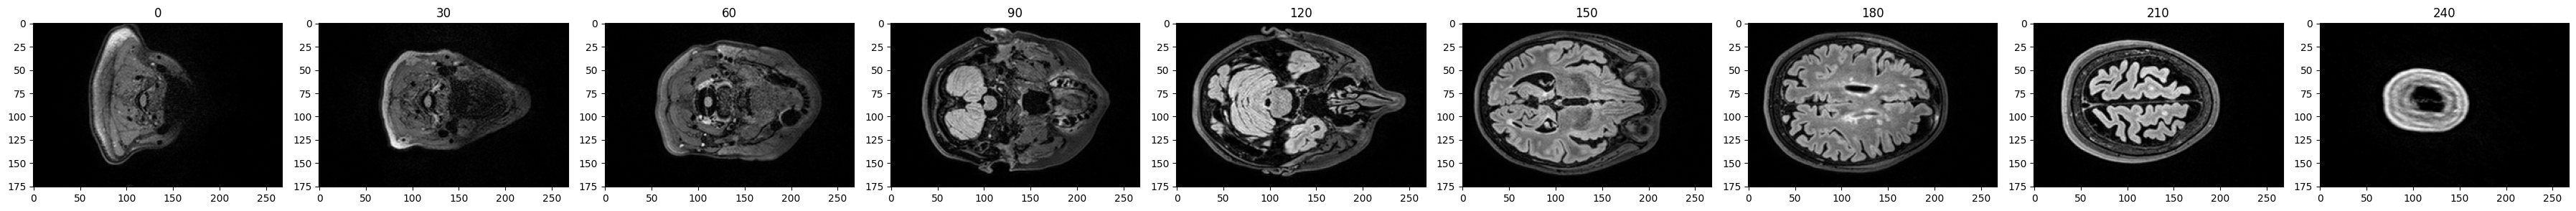

In [ ]:
slices = load_nii_image(nii_path, plane='axial')
MediaPlayer.display_slides_with_step(slices, step=30)

## Pre Processing

In [ ]:
class ImageProcessor:
    # Méthode pour redimensionner une image
    @staticmethod
    def resize_images(image1, image2):
        height = min(image1.shape[0], image2.shape[0])
        width = min(image1.shape[1], image2.shape[1])
        image1_resized = resize(image1, (height, width))
        image2_resized = resize(image2, (height, width))
        return image1_resized, image2_resized

    # Normaliser les valeurs entre -1 et 1
    @staticmethod
    def normalize(image):
        return (image - image.min()) / (image.max() - image.min())

## Interpolation Methods

#### Morphological Median

In [ ]:
class MorphologicalMedian:
    def __init__(self, image1, image2, structuring_element):
        self.image1 = img_as_ubyte(image1)
        self.image2 = img_as_ubyte(image2)
        self.structuring_element = structuring_element

    def cone_dilation(self, I):
        # Ajoute 1 à I avec gestion de dépassement de capacité
        I_plus_one = np.clip(I + 1, 0, 255)
        # Applique dilation et prend le maximum avec I_plus_one
        out = np.maximum(I_plus_one, dilation(I, self.structuring_element))
        return out

    def cone_erosion(self, I):
        # Soustrait 1 à I avec gestion de dépassement de capacité
        I_minus_one = np.clip(I - 1, 0, 255)
        # Applique erosion et prend le minimum avec I_minus_one
        out = np.minimum(I_minus_one, erosion(I, self.structuring_element))
        return out

    def calculate_median(self):
        image1, image2 = self.image1, self.image2
        if image1.shape != image2.shape:
            assert image1.ndim == image2.ndim == 2, 'Images must be the same shape and 2D'

        # Initialisation des variables :
        z = np.minimum(image1, image2)
        w = np.maximum(image1, image2)
        m = np.copy(z)
        mi = np.zeros(z.shape, dtype=np.uint8)

        iterations = 0  # Compteur d'itérations pour suivre le nombre d'itérations effectuées

        # Boucle jusqu'à ce que le médian calculé (mi) ne change plus entre les itérations
        while not np.array_equal(m, mi):
            m = np.copy(mi)  # Mise à jour de m avec le dernier médian calculé
            # Applique les opérations coniques
            z = self.cone_dilation(z)
            w = self.cone_erosion(w)
            mi = np.maximum(np.minimum(z, w), m)  # Calcul du nouveau médian (mi)

            iterations += 1  # Incrémente le compteur d'itérations

        return mi, iterations

#### Linear Interpolation

In [ ]:
class ImageInterpolation:
    def __init__(self, image1, image2):
        self.image1 = img_as_ubyte(image1)  # Convert the first image to 8-bit unsigned bytes
        self.image2 = img_as_ubyte(image2)  # Convert the second image to 8-bit unsigned bytes

    def interpolate_linear(self, t):
        t = np.clip(t, 0, 1)  # Ensure the interpolation factor is within the valid range
        # Calculate the interpolated image using linear blending formula
        interpolated_image = (1 - t) * self.image1 + t * self.image2
        # Return the interpolated image, ensuring pixel values remain within byte range
        return np.clip(interpolated_image, 0, 255).astype(np.uint8)

## Image Quality Metrics

In [ ]:
from skimage.metrics import mean_squared_error, structural_similarity, peak_signal_noise_ratio

def calculate_metrics(true_image, test_image):
      """
      Calcule et retourne un dictionnaire contenant les métriques MSE, SSIM, MAE, et PSNR.
      """
      mse_value = mean_squared_error(true_image, test_image)
      ssim_value = structural_similarity(true_image, test_image, data_range=test_image.max() - test_image.min())
      psnr_value = peak_signal_noise_ratio(true_image, test_image, data_range=test_image.max() - test_image.min())

      return {
          'MSE': mse_value,
          'RMSE': np.sqrt(mse_value),
          'SSIM': ssim_value,
          'PSNR': psnr_value
      }

## Process Median Morphological on MRI Slides



#### Let's process

Apply on consecutive slides

In [ ]:
def apply_processing(slices, method, structuring_element=disk(1), display=True):

    metrics_by_slices = {}

    for i in range(len(slices) - 2):
        image1 = slices[i]
        image2 = slices[i+2]

        # Vérifie si l'une des images contient uniquement des zéros et saute l'itération si c'est le cas. Pour éviter de diviser par 0 lors de la normalization
        if np.all(image1 == 0) or np.all(image2 == 0):
            continue  # Saute cette itération

        image1 = ImageProcessor.normalize(image1)
        image2 = ImageProcessor.normalize(image2)
        true_image = slices[i+1]  # Image réelle à comparer

        if method == "morphological median interpolation":
            # Calcul du médian morphologique
            interpolated_image, _ = MorphologicalMedian(image1, image2, structuring_element).calculate_median()
        elif method == "linear interpolation":
            interpolated_image = ImageInterpolation(image1, image2).interpolate_linear(t=0.5)
        else:
            interpolated_image = image2

        # Calcul des métriques
        metrics = calculate_metrics(true_image, interpolated_image)
        #metrics['Execution Time'] = execution_time

        # Stockage des métriques
        metrics_by_slices[i+1] = metrics

        # Affichage des images si demandé
        if display:
            titles = [f'Slice {i}', '~ Image Interpolated', f'True Image : {i+1}', f'Slice {i+2}']
            mse, rmse, ssim, psnr = metrics['MSE'], metrics['RMSE'], metrics['SSIM'], metrics['PSNR']
            x_labels = ['', f'RMSE: {rmse:.3f}, SSIM: {ssim:.3f}, PSNR: {psnr:.3f}', '', '']
            MediaPlayer.display_images(images=[slices[i], interpolated_image, slices[i+1], slices[i+2]], titles=titles, x_labels=x_labels)

    return metrics_by_slices

In [ ]:
%time metrics_by_slices = apply_processing(slices=slices, method="linear interpolation", display=False)

CPU times: user 2.06 s, sys: 5.15 ms, total: 2.06 s
Wall time: 4.88 s


In [ ]:
%time metrics_by_slices = apply_processing(slices=slices, method="morphological median interpolation", display=False)

CPU times: user 5.85 s, sys: 5.89 ms, total: 5.85 s
Wall time: 6.33 s


In [ ]:
results = {}
for method in ["morphological median interpolation", "linear interpolation"]:
    %time metrics_by_slices = apply_processing(slices=slices, method=method, display=False)
    results[method] = metrics_by_slices

CPU times: user 3.97 s, sys: 1.89 ms, total: 3.97 s
Wall time: 3.98 s
CPU times: user 1.34 s, sys: 457 µs, total: 1.34 s
Wall time: 1.35 s


# Graphs

## Morphological median interpolation and metrics

### Metrics VS SLice: Overview

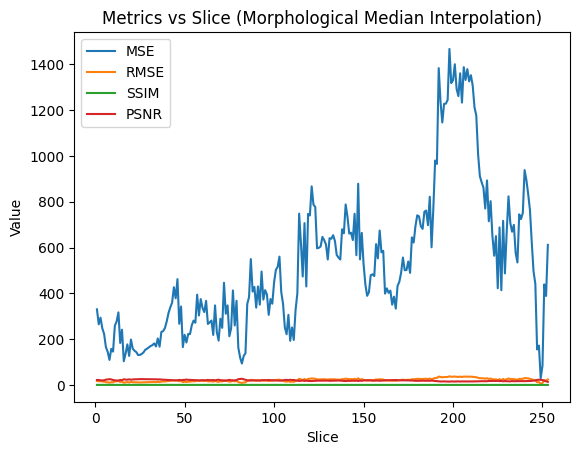

In [ ]:
metrics = ['MSE', 'RMSE', 'SSIM', 'PSNR']

for metric in metrics:
    x = list(results['morphological median interpolation'].keys())
    y = [results['morphological median interpolation'][key][metric] for key in x]
    plt.plot(x, y, label=metric)

plt.xlabel('Slice')
plt.ylabel('Value')
plt.title('Metrics vs Slice (Morphological Median Interpolation)')
plt.legend()
plt.show()

### Metrics VS Slice

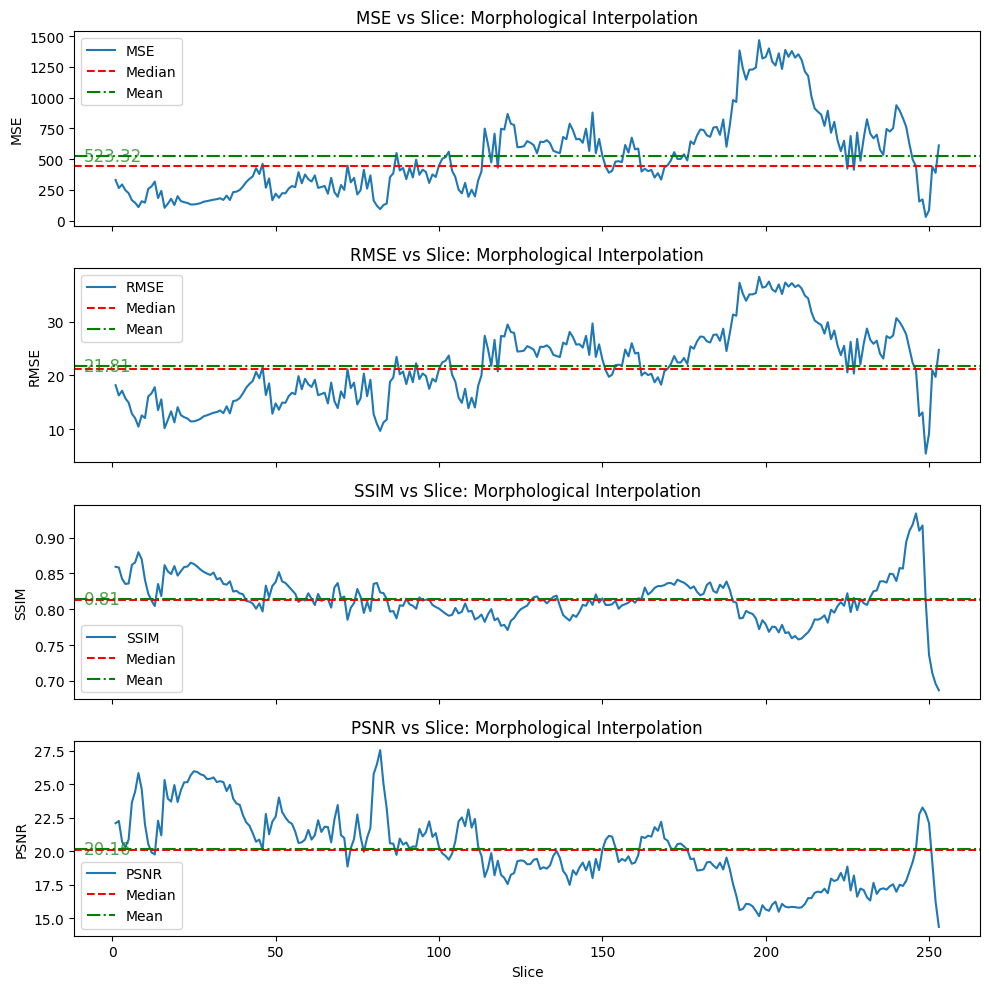

In [ ]:
metrics = ['MSE', 'RMSE', 'SSIM', 'PSNR']

fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 10), sharex=True)

for i, metric in enumerate(metrics):
    x = list(results['morphological median interpolation'].keys())
    y = [results['morphological median interpolation'][key][metric] for key in x]

    median_value = np.median(y)
    mean_value = np.mean(y)

    axs[i].plot(x, y, label=metric)
    axs[i].axhline(y=median_value, color='r', linestyle='--', label='Median')
    axs[i].axhline(y=mean_value, color='g', linestyle='-.', label='Mean')

    axs[i].text(0.01, mean_value, f'{mean_value:.2f}', transform=axs[i].get_yaxis_transform(),
                verticalalignment='center', horizontalalignment='left', color='g', fontsize=12, alpha=0.7)
   # axs[i].text(0.01, median_value, f'{median_value:.2f}', transform=axs[i].get_yaxis_transform(),
   #             verticalalignment='center', horizontalalignment='left', color='r', fontsize=12, alpha=0.7)

    axs[i].set_ylabel(metric)
    axs[i].set_title(f"{metric} vs Slice: Morphological Interpolation")
    axs[i].legend()

plt.xlabel('Slice')
plt.tight_layout()
plt.show()

## Linear interpolation and metrics

###Metrics VS Slice: Overview

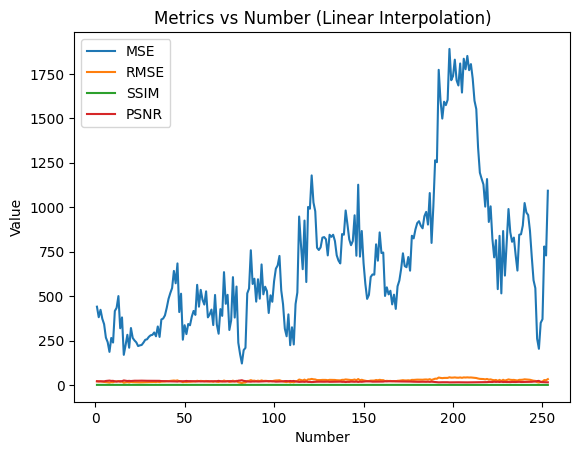

In [ ]:
metrics = ['MSE', 'RMSE', 'SSIM', 'PSNR']

for metric in metrics:
    x = list(results['linear interpolation'].keys())
    y = [results['linear interpolation'][key][metric] for key in x]
    plt.plot(x, y, label=metric)

plt.xlabel('Number')
plt.ylabel('Value')
plt.title('Metrics vs Number (Linear Interpolation)')
plt.legend()
plt.show()

###Metrics VS Slice

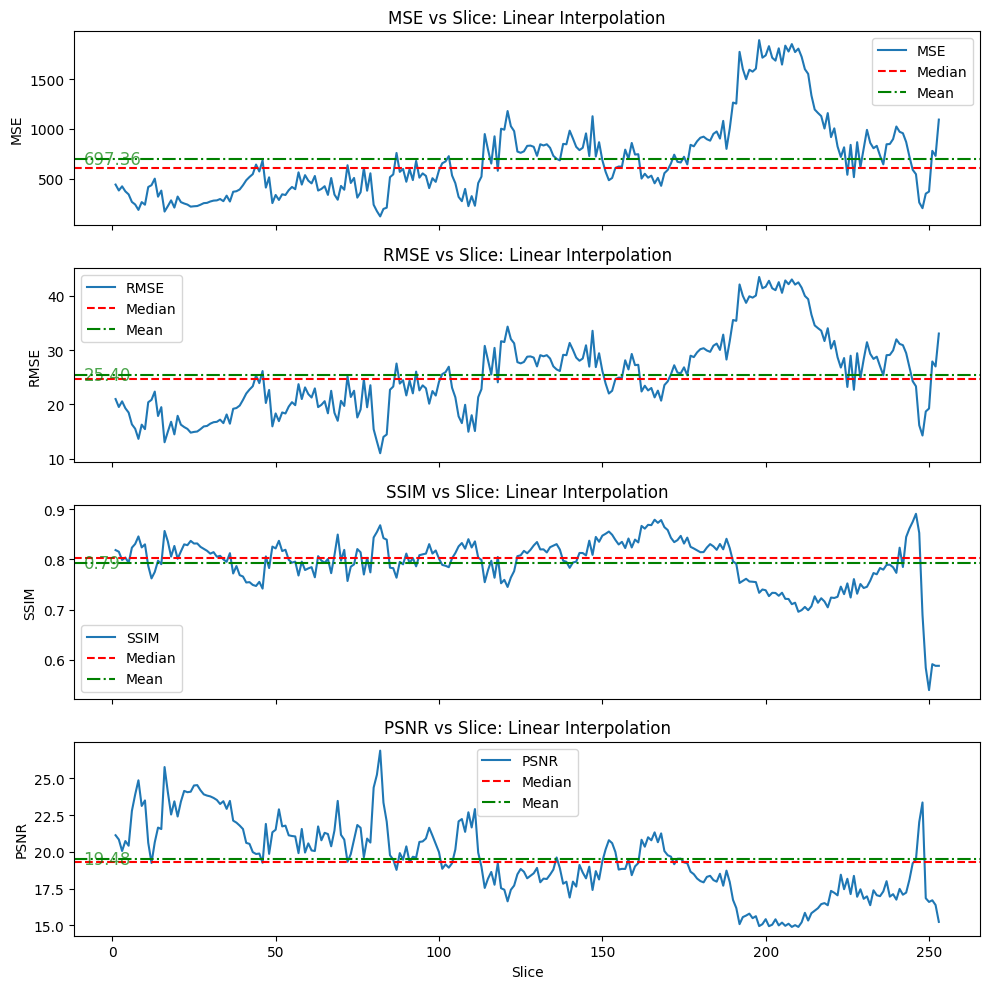

In [ ]:
import numpy as np

metrics = ['MSE', 'RMSE', 'SSIM', 'PSNR']

fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 10), sharex=True)

for i, metric in enumerate(metrics):
    x = list(results['linear interpolation'].keys())
    y = [results['linear interpolation'][key][metric] for key in x]

    median_value = np.median(y)
    mean_value = np.mean(y)

    axs[i].plot(x, y, label=metric)
    axs[i].axhline(y=median_value, color='r', linestyle='--', label='Median')
    axs[i].axhline(y=mean_value, color='g', linestyle='-.', label='Mean')

    axs[i].text(0.01, mean_value, f'{mean_value:.2f}', transform=axs[i].get_yaxis_transform(),
                verticalalignment='center', horizontalalignment='left', color='g', fontsize=12, alpha=0.7)

    axs[i].set_ylabel(metric)
    axs[i].set_title(f"{metric} vs Slice: Linear Interpolation")
    axs[i].legend()

plt.xlabel('Slice')
plt.tight_layout()
plt.show()

# Methods Comparison

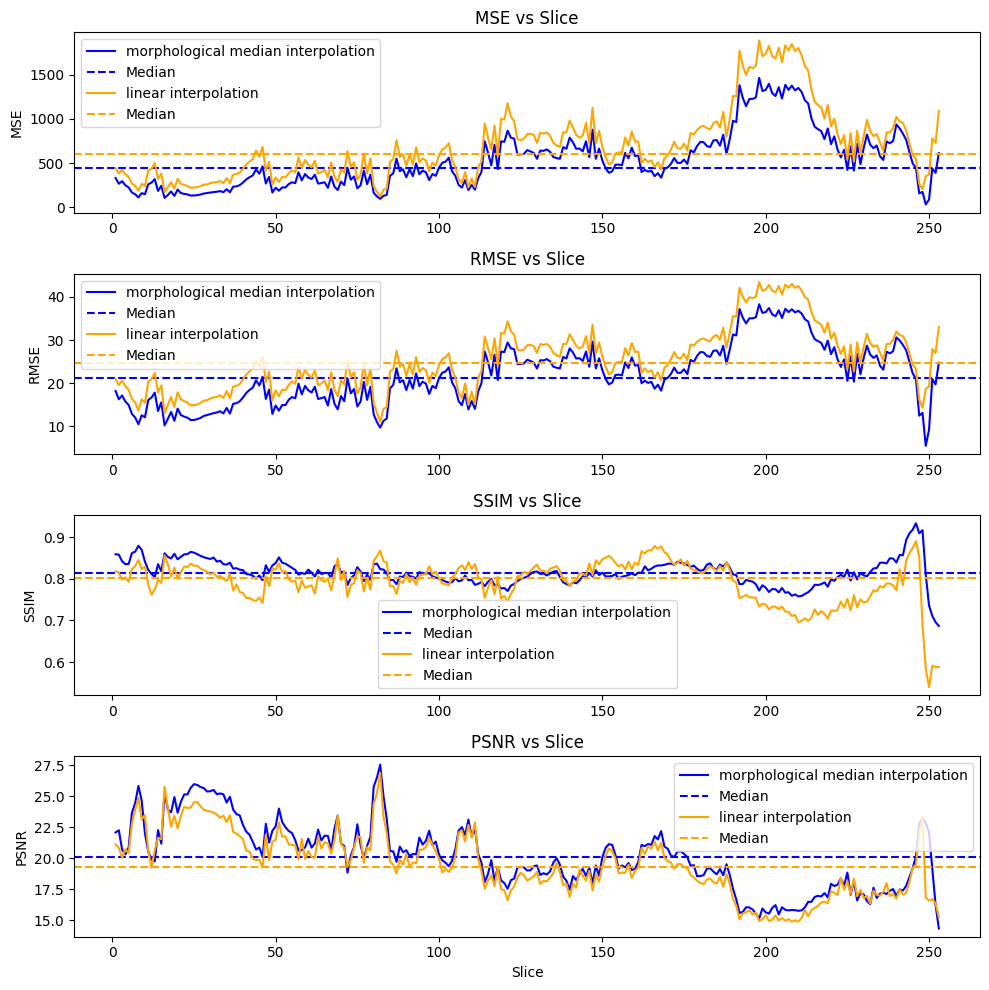

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Liste des métriques à tracer
metrics = ['MSE', 'RMSE', 'SSIM', 'PSNR']

# Créer une figure et des axes pour chaque métrique
fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 10))

# Méthodes à tracer
methods = ['morphological median interpolation', 'linear interpolation']

# Définir les couleurs pour chaque méthode
colors = ['b', 'orange']

# Plot des graphiques pour chaque métrique
for i, metric in enumerate(metrics):
    # Plot pour chaque méthode
    for method, color in zip(methods, colors):
        x = list(results[method].keys())
        y = [results[method][key][metric] for key in x]

        median_value = np.median(y)

        axs[i].plot(x, y, label=method, color=color)

        axs[i].axhline(y=median_value, color=color, linestyle='--', label='Median')

    axs[i].set_ylabel(metric)
    axs[i].set_title(f"{metric} vs Slice")
    axs[i].legend()

# Label de l'axe des abscisses
plt.xlabel('Slice')

# Ajustement de la disposition
plt.tight_layout()

# Affichage des graphiques combinés
plt.show()

# Successive interpolations with a gap: 2, 4, 10, 14, 18

In [ ]:
def process_images(slices, distance, structuring_element, method, display=True):
    # Détermination de l'index de la tranche centrale
    center_index = len(slices) // 2

    # Dictionnaires pour stocker les métriques
    metrics_by_slices = {}
    pas = distance
    tampon = 0
    a_index = center_index
    # Traitement à partir du centre vers la tranche B, à la fois vers le début et la fin du tableau
    for direction in (-1, 1):  # -1 pour aller vers le début, 1 pour aller vers la fin
        while 0 <= center_index + distance * direction < len(slices):

            if tampon == 5:
                tampon = 0
                distance = pas
                a_index = center_index
                break

            # Indices des tranches à comparer
            b_index = center_index + distance * direction
            m_index = (a_index + b_index) // 2

            # Application de la médiane
            image_a = ImageProcessor.normalize(slices[a_index])
            image_b = ImageProcessor.normalize(slices[b_index])
            true_image = slices[m_index]
            #median_image, _ = MorphologicalMedian(image_a, image_b, structuring_element).calculate_median()
            if method == "morphological median interpolation":
            # Calcul du médian morphologique
              interpolated_image, _ = MorphologicalMedian(image_a, image_b, structuring_element).calculate_median()
            elif method == "linear interpolation":
              interpolated_image = ImageInterpolation(image_a, image_b).interpolate_linear(t=0.5)

            # Calcul des métriques pour l'image médiane obtenue
            metrics = calculate_metrics(true_image, interpolated_image)

            # Stockage des métriques
            metrics_by_slices[m_index] = metrics

            # Affichage des images si demandé
            if display:
                titles = [f'Slice 1 : {a_index}', '~ Median Image Computed', f'True Image : {m_index}', f'Slice 2 : {b_index}']
                mse, rmse, ssim, psnr = metrics['MSE'], metrics['RMSE'], metrics['SSIM'], metrics['PSNR']
                x_labels = ['', f'RMSE: {rmse:.3f}, SSIM: {ssim:.3f}, PSNR: {psnr:.3f}', '', '']
                MediaPlayer.display_images(images=[image_a, interpolated_image, true_image, image_b], titles=titles, x_labels=x_labels)

            # Incrémentation de la distance pour l'itération suivante
            a_index = center_index + distance * direction
            distance += pas
            tampon += 1

    return metrics_by_slices

%time metrics_by_slices_median = process_images(slices, distance=4, structuring_element=disk(1), method='morphological median interpolation',display=False)
%time metrics_by_slices_linear = process_images(slices, distance=4, structuring_element=disk(1), method='linear interpolation',display=False)

CPU times: user 182 ms, sys: 0 ns, total: 182 ms
Wall time: 182 ms
CPU times: user 57.1 ms, sys: 0 ns, total: 57.1 ms
Wall time: 57.7 ms


In [ ]:
#distance 2
%time metrics_by_slices_2_median = process_images(slices, distance=2, structuring_element=disk(1), method='morphological median interpolation', display=False)
%time metrics_by_slices_2_linear = process_images(slices, distance=2, structuring_element=disk(1), method='linear interpolation', display=False)

CPU times: user 174 ms, sys: 0 ns, total: 174 ms
Wall time: 176 ms
CPU times: user 65.1 ms, sys: 789 µs, total: 65.9 ms
Wall time: 65.7 ms


In [ ]:
#distance 4
%time metrics_by_slices_4_median = process_images(slices, distance=4, structuring_element=disk(1), method='morphological median interpolation', display=False)
%time metrics_by_slices_4_linear = process_images(slices, distance=2, structuring_element=disk(1), method='linear interpolation', display=False)

CPU times: user 297 ms, sys: 1.6 ms, total: 298 ms
Wall time: 307 ms
CPU times: user 72.9 ms, sys: 859 µs, total: 73.8 ms
Wall time: 81.6 ms


In [ ]:
#distance 10
%time metrics_by_slices_10_median = process_images(slices, distance=10, structuring_element=disk(1), method='morphological median interpolation', display=False)
%time metrics_by_slices_10_linear = process_images(slices, distance=10, structuring_element=disk(1), method='linear interpolation', display=False)

CPU times: user 353 ms, sys: 3.27 ms, total: 356 ms
Wall time: 394 ms
CPU times: user 82.7 ms, sys: 0 ns, total: 82.7 ms
Wall time: 130 ms


In [ ]:
#distance 14
%time metrics_by_slices_14_median = process_images(slices, distance=14, structuring_element=disk(1), method='morphological median interpolation', display=False)
%time metrics_by_slices_14_linear = process_images(slices, distance=14, structuring_element=disk(1), method='linear interpolation', display=False)

CPU times: user 396 ms, sys: 0 ns, total: 396 ms
Wall time: 429 ms
CPU times: user 79.2 ms, sys: 1.17 ms, total: 80.3 ms
Wall time: 82.6 ms


In [ ]:
#distance 18
%time metrics_by_slices_18_median = process_images(slices, distance=18, structuring_element=disk(1), method='morphological median interpolation', display=False)
%time metrics_by_slices_18_linear = process_images(slices, distance=18, structuring_element=disk(1), method='linear interpolation', display=False)

CPU times: user 415 ms, sys: 0 ns, total: 415 ms
Wall time: 429 ms
CPU times: user 78.2 ms, sys: 0 ns, total: 78.2 ms
Wall time: 91.9 ms


In [ ]:
# Extraire les clés (numéros de coupes) du dictionnaire
slices_numb_2 = list(metrics_by_slices_2_median.keys())
slices_numb_4 = list(metrics_by_slices_4_median.keys())
slices_numb_10 = list(metrics_by_slices_10_median.keys())
slices_numb_14 = list(metrics_by_slices_14_median.keys())
slices_numb_18 = list(metrics_by_slices_18_median.keys())

# Trier les numéros de coupes
slices_numb_2.sort()
slices_numb_4.sort()
slices_numb_10.sort()
slices_numb_14.sort()
slices_numb_18.sort()

# Créer un nouveau dictionnaire trié
metrics_by_slices_2_median = {slice_num: metrics_by_slices_2_median[slice_num] for slice_num in slices_numb_2}
metrics_by_slices_4_median = {slice_num: metrics_by_slices_4_median[slice_num] for slice_num in slices_numb_4}
metrics_by_slices_10_median = {slice_num: metrics_by_slices_10_median[slice_num] for slice_num in slices_numb_10}
metrics_by_slices_14_median = {slice_num: metrics_by_slices_14_median[slice_num] for slice_num in slices_numb_14}
metrics_by_slices_18_median = {slice_num: metrics_by_slices_18_median[slice_num] for slice_num in slices_numb_18}

In [ ]:
# Extraire les clés (numéros de coupes) du dictionnaire
slices_numb_2 = list(metrics_by_slices_2_linear.keys())
slices_numb_4 = list(metrics_by_slices_4_linear.keys())
slices_numb_10 = list(metrics_by_slices_10_linear.keys())
slices_numb_14 = list(metrics_by_slices_14_linear.keys())
slices_numb_18 = list(metrics_by_slices_18_linear.keys())

# Trier les numéros de coupes
slices_numb_2.sort()
slices_numb_4.sort()
slices_numb_10.sort()
slices_numb_14.sort()
slices_numb_18.sort()

# Créer un nouveau dictionnaire trié
metrics_by_slices_2_linear = {slice_num: metrics_by_slices_2_linear[slice_num] for slice_num in slices_numb_2}
metrics_by_slices_4_linear = {slice_num: metrics_by_slices_4_linear[slice_num] for slice_num in slices_numb_4}
metrics_by_slices_10_linear = {slice_num: metrics_by_slices_10_linear[slice_num] for slice_num in slices_numb_10}
metrics_by_slices_14_linear = {slice_num: metrics_by_slices_14_linear[slice_num] for slice_num in slices_numb_14}
metrics_by_slices_18_linear = {slice_num: metrics_by_slices_18_linear[slice_num] for slice_num in slices_numb_18}

# Graph for median method

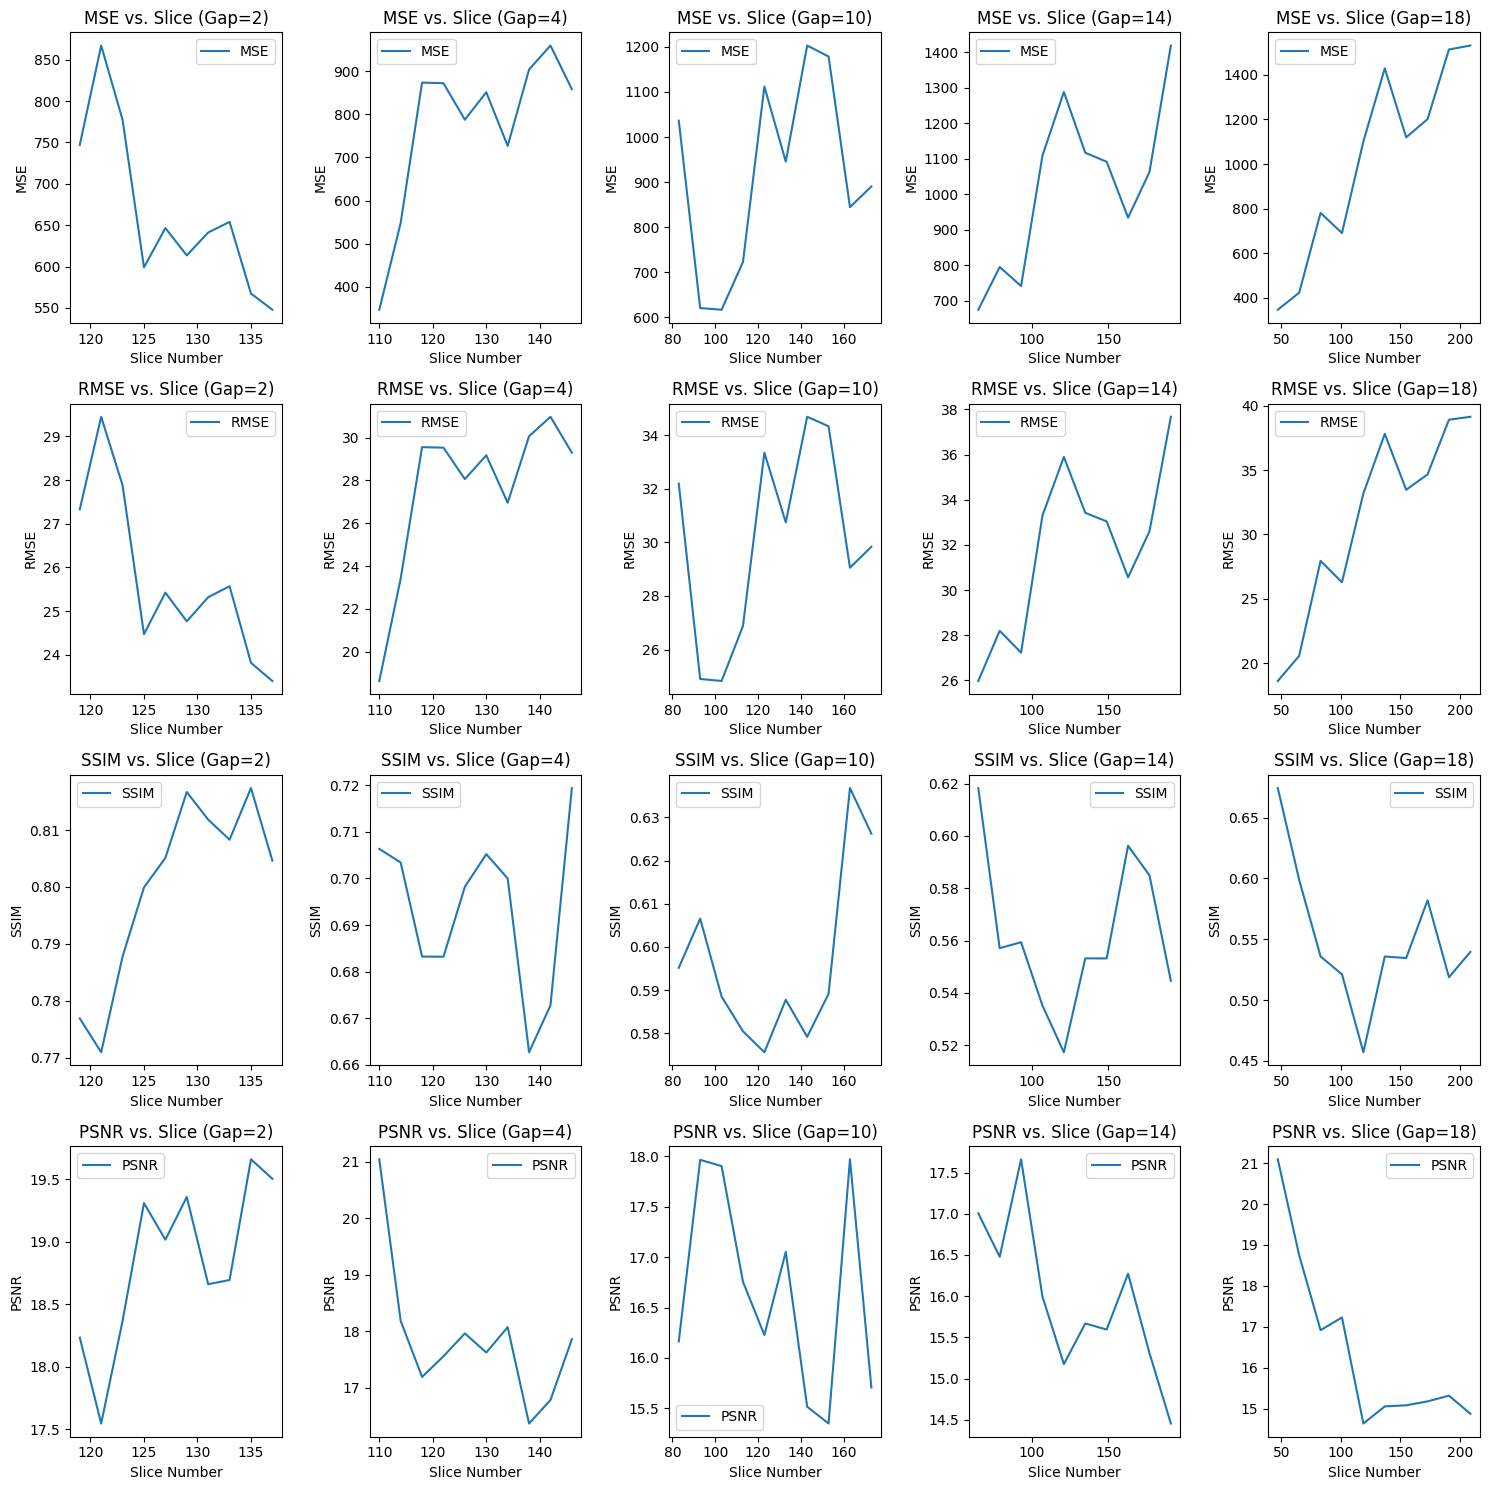

In [ ]:
# Define functions to convert dictionaries to DataFrames
def dict_to_dataframe(metrics_dict):
    return pd.DataFrame(metrics_dict)

# Extracting data for each metric from each dataframe
metrics_dfs = [metrics_by_slices_2_median, metrics_by_slices_4_median, metrics_by_slices_10_median, metrics_by_slices_14_median, metrics_by_slices_18_median]
metric_names = ['MSE', 'RMSE', 'SSIM', 'PSNR']
gaps = [2, 4, 10, 14, 18]

# Plotting the value of each metric by the number of the slice for each dataframe
fig, axs = plt.subplots(len(metric_names), len(metrics_dfs), figsize=(15, 15))

for i, metric_name in enumerate(metric_names):
    for j, metrics_dict in enumerate(metrics_dfs):
        ax = axs[i, j]

        # Convert dictionary to DataFrame
        df = dict_to_dataframe(metrics_dict)

        slices_numbers = df.columns.tolist()
        metric_values = df.loc[metric_name].tolist()
        ax.plot(slices_numbers, metric_values, label=metric_name)
        ax.set_title(f'{metric_name} vs. Slice (Gap={gaps[j]})')
        ax.set_xlabel('Slice Number')
        ax.set_ylabel(metric_name)
        ax.legend()

plt.tight_layout()
plt.show()

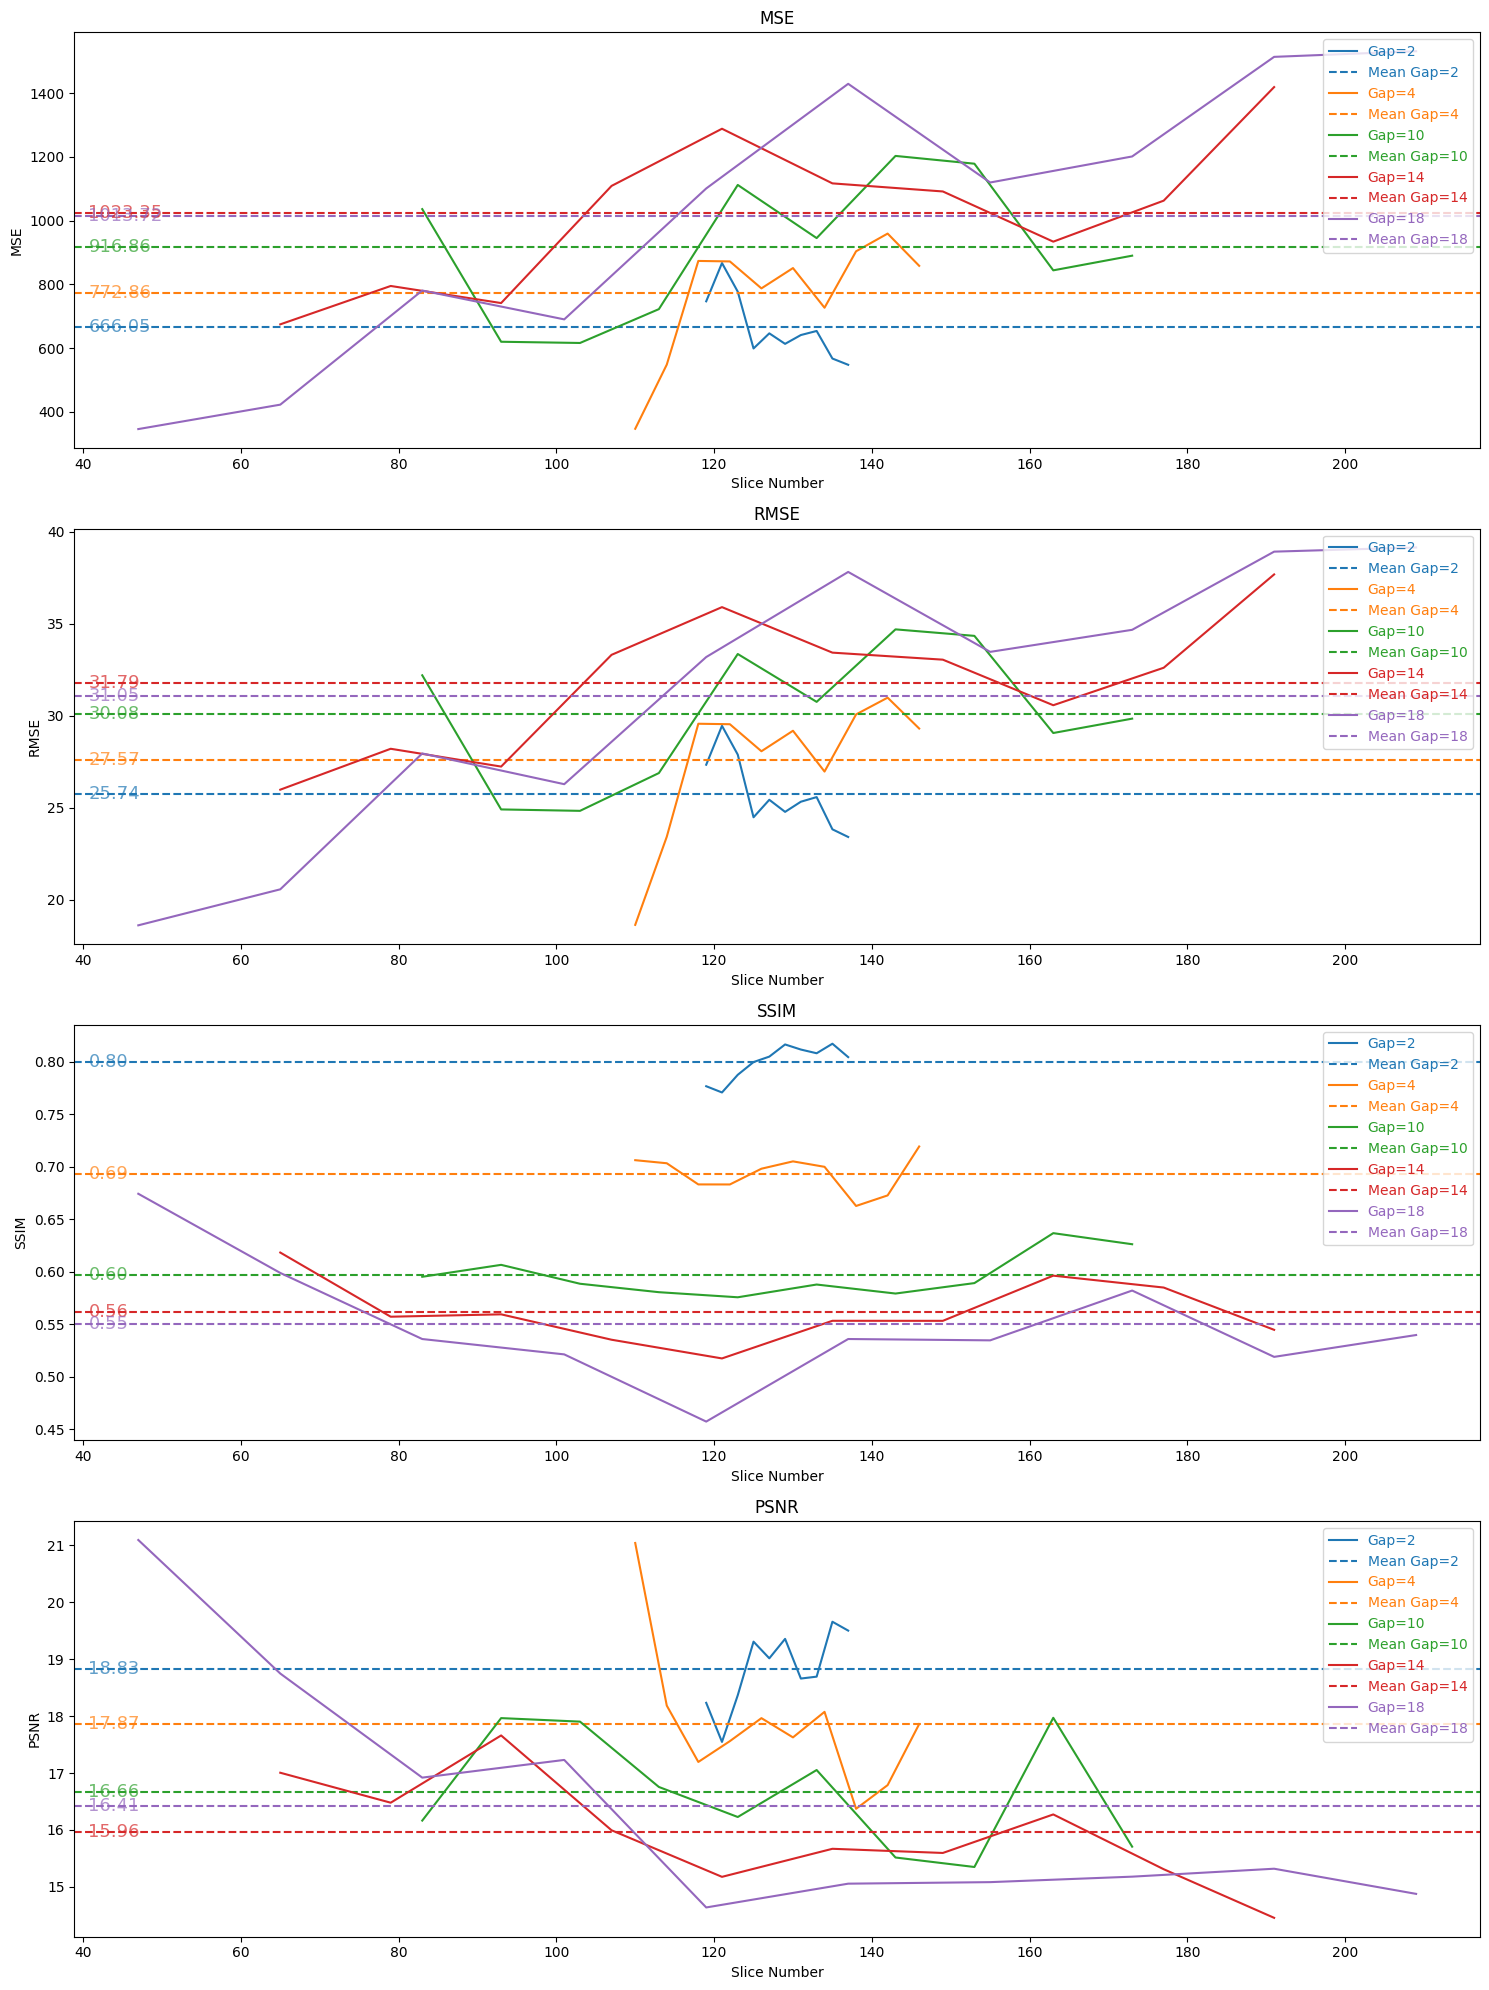

In [ ]:
import numpy as np

# Define functions to convert dictionaries to DataFrames
def dict_to_dataframe(metrics_dict):
    return pd.DataFrame(metrics_dict)

# Extracting data for each metric from each dataframe
metrics_dfs = [metrics_by_slices_2_median, metrics_by_slices_4_median, metrics_by_slices_10_median, metrics_by_slices_14_median, metrics_by_slices_18_median]
metric_names = ['MSE', 'RMSE', 'SSIM', 'PSNR']
gaps = [2, 4, 10, 14, 18]

# Plotting the value of each metric by the number of the slice for all dataframes
fig, axs = plt.subplots(len(metric_names), 1, figsize=(15, 20))

for i, metric_name in enumerate(metric_names):
    gap_colors = []  # Store colors for each gap plot
    for j, metrics_dict in enumerate(metrics_dfs):
        # Convert dictionary to DataFrame
        df = dict_to_dataframe(metrics_dict)

        slices_numbers = df.columns.tolist()
        metric_values = df.loc[metric_name].tolist()

        # Plotting the metric values with different colors for each dataframe
        line = axs[i].plot(slices_numbers, metric_values, label=f'Gap={gaps[j]}')
        color = line[0].get_color()  # Get the color used for this gap plot
        gap_colors.append(color)  # Store the color

        # Calculate mean value for each gap
        mean_value = np.mean(metric_values)

        # Plotting mean value as a horizontal line with the same color
        axs[i].axhline(mean_value, linestyle='--', color=color, label=f'Mean Gap={gaps[j]}')

        # Print the mean value next to the plot (closer to the graph) with improved readability
        axs[i].text(0.01, mean_value, f'{mean_value:.2f}', transform=axs[i].get_yaxis_transform(),
                    verticalalignment='center', horizontalalignment='left', color=color, fontsize=13, alpha=0.7)

    axs[i].set_title(metric_name)
    axs[i].set_xlabel('Slice Number')
    axs[i].set_ylabel(metric_name)

    # Set legend with correct colors
    legend = axs[i].legend(loc='upper right')
    for line, text in zip(legend.get_lines(), legend.get_texts()):
        text.set_color(line.get_color())

plt.tight_layout()
plt.show()

# Graph for linear method

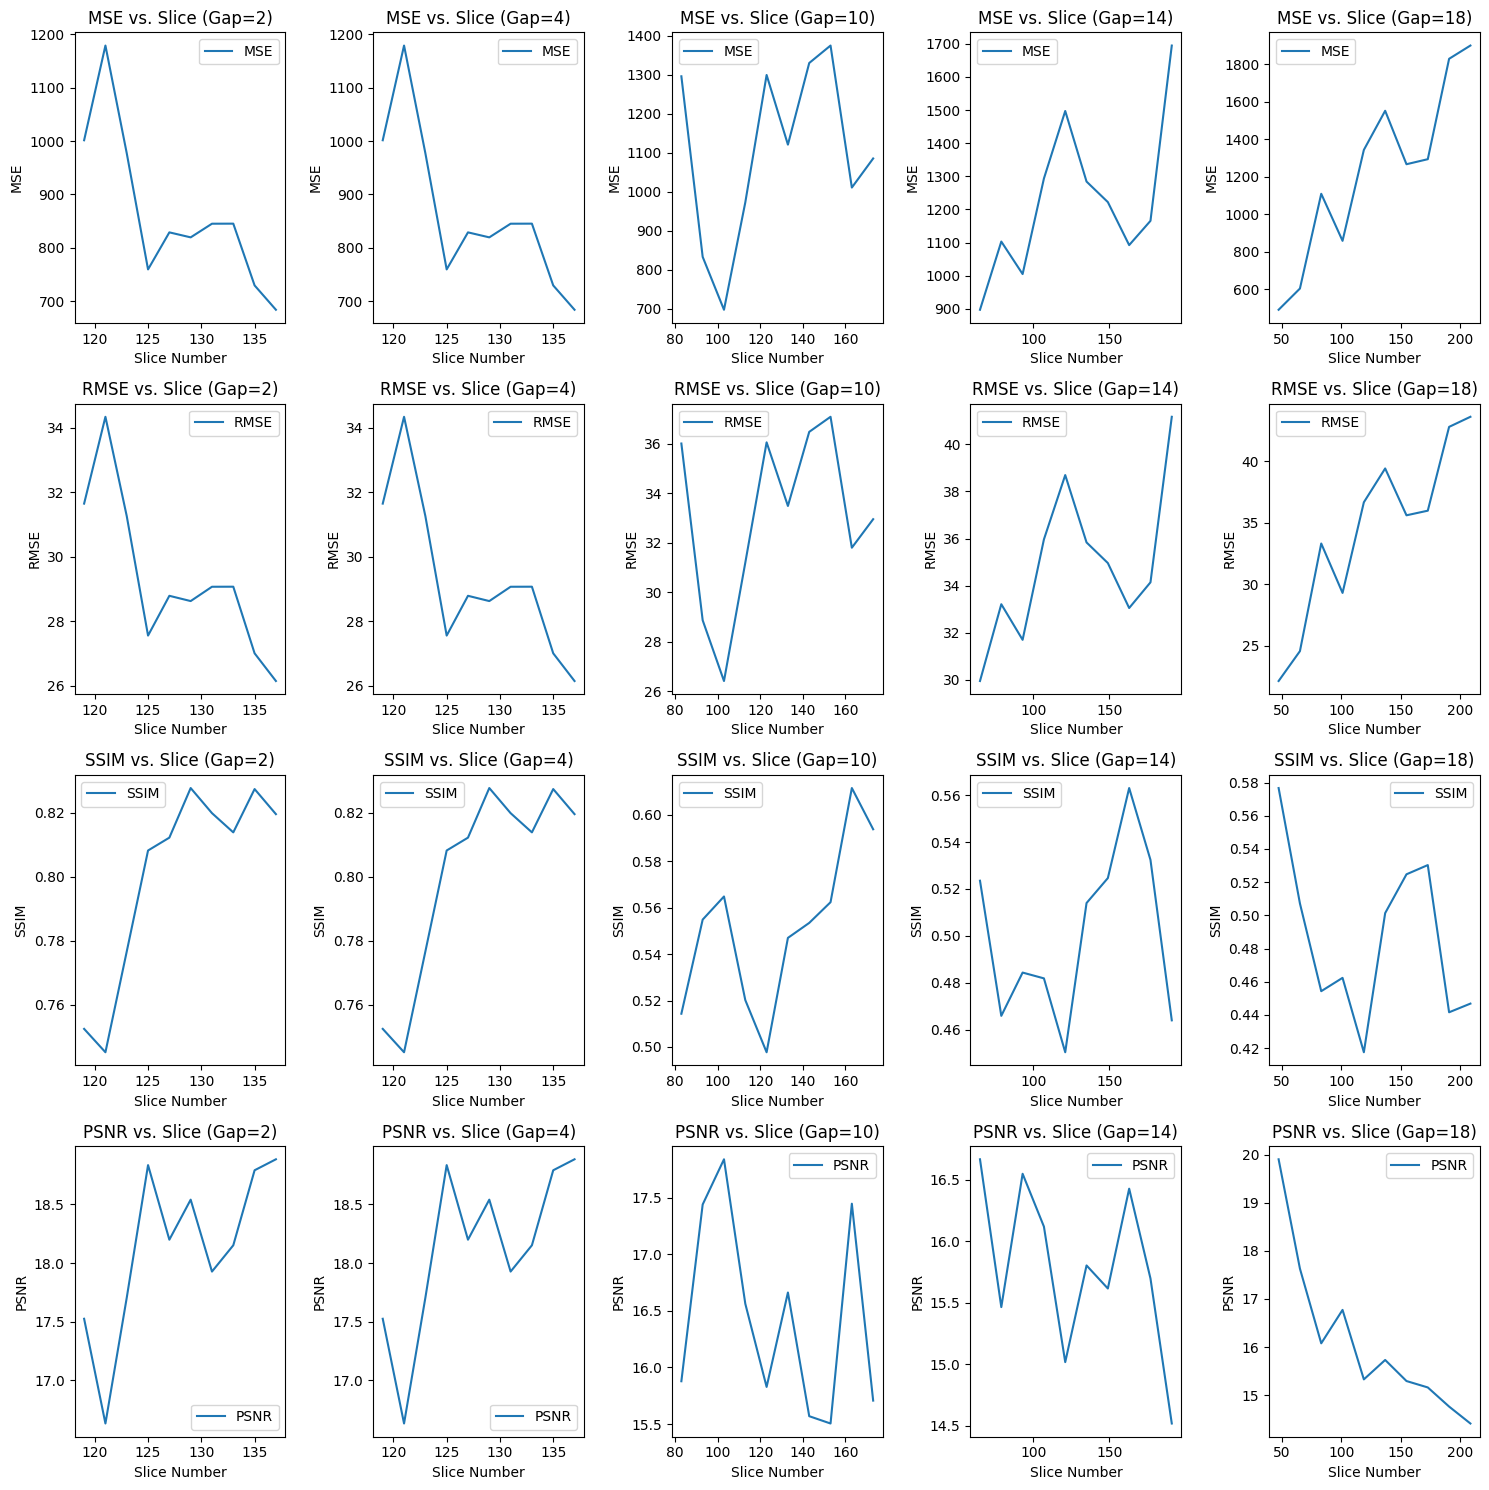

In [ ]:
# Define functions to convert dictionaries to DataFrames
def dict_to_dataframe(metrics_dict):
    return pd.DataFrame(metrics_dict)

# Extracting data for each metric from each dataframe
metrics_dfs = [metrics_by_slices_2_linear, metrics_by_slices_4_linear, metrics_by_slices_10_linear, metrics_by_slices_14_linear, metrics_by_slices_18_linear]
metric_names = ['MSE', 'RMSE', 'SSIM', 'PSNR']
gaps = [2, 4, 10, 14, 18]

# Plotting the value of each metric by the number of the slice for each dataframe
fig, axs = plt.subplots(len(metric_names), len(metrics_dfs), figsize=(15, 15))

for i, metric_name in enumerate(metric_names):
    for j, metrics_dict in enumerate(metrics_dfs):
        ax = axs[i, j]

        # Convert dictionary to DataFrame
        df = dict_to_dataframe(metrics_dict)

        slices_numbers = df.columns.tolist()
        metric_values = df.loc[metric_name].tolist()
        ax.plot(slices_numbers, metric_values, label=metric_name)
        ax.set_title(f'{metric_name} vs. Slice (Gap={gaps[j]})')
        ax.set_xlabel('Slice Number')
        ax.set_ylabel(metric_name)
        ax.legend()

plt.tight_layout()
plt.show()

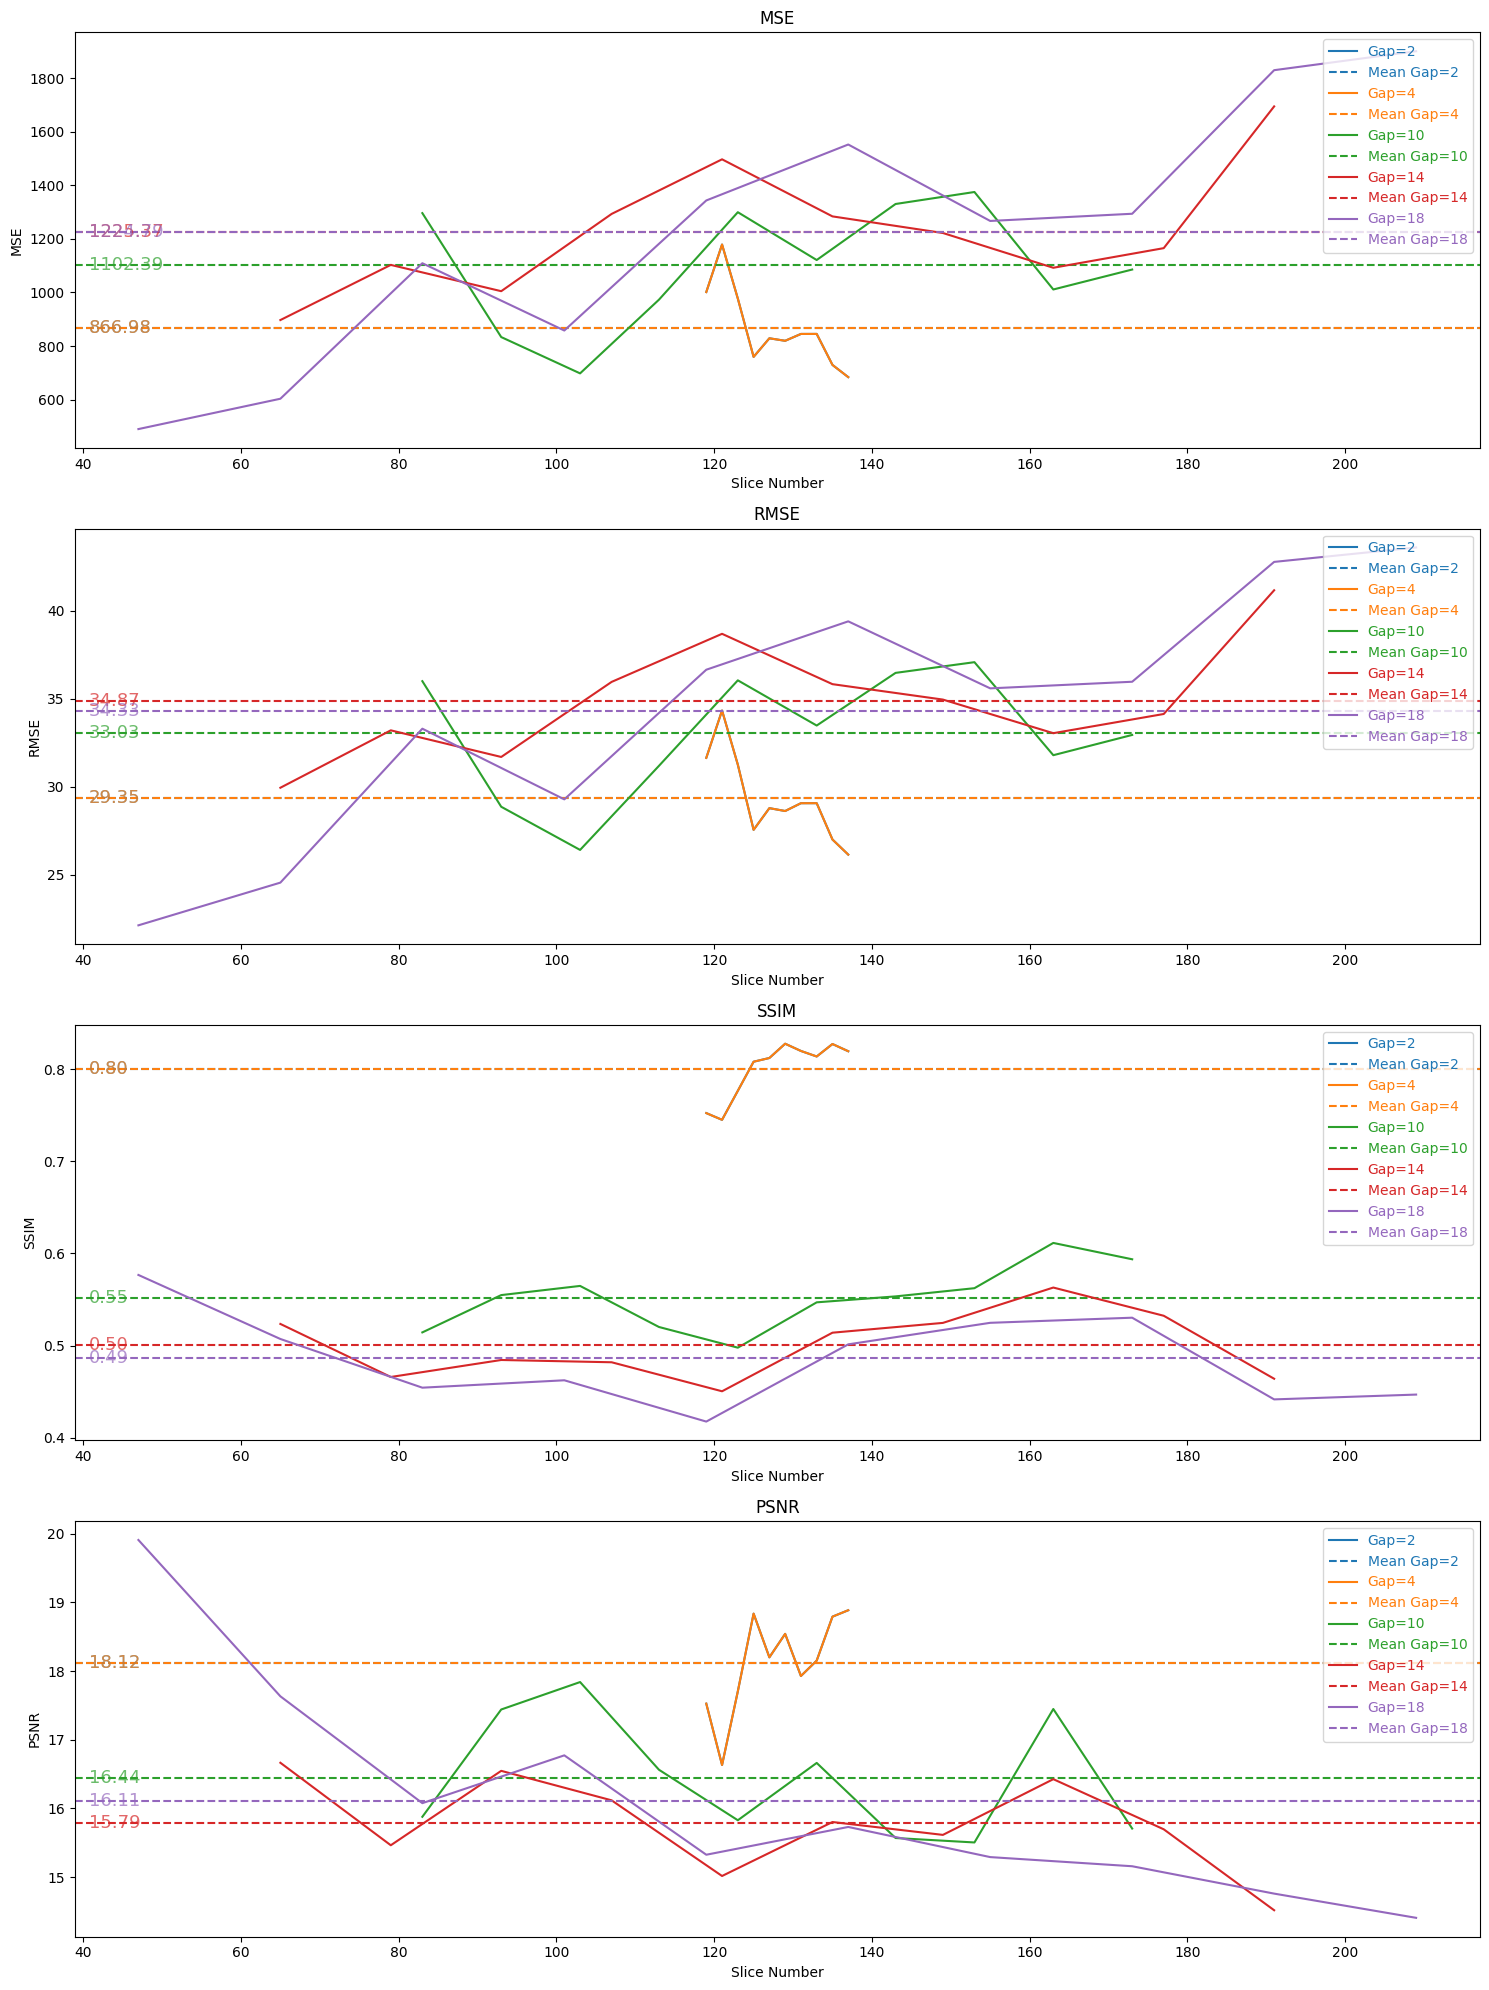

In [ ]:
import numpy as np

# Define functions to convert dictionaries to DataFrames
def dict_to_dataframe(metrics_dict):
    return pd.DataFrame(metrics_dict)

# Extracting data for each metric from each dataframe
metrics_dfs = [metrics_by_slices_2_linear, metrics_by_slices_4_linear, metrics_by_slices_10_linear, metrics_by_slices_14_linear, metrics_by_slices_18_linear]
metric_names = ['MSE', 'RMSE', 'SSIM', 'PSNR']
gaps = [2, 4, 10, 14, 18]

# Plotting the value of each metric by the number of the slice for all dataframes
fig, axs = plt.subplots(len(metric_names), 1, figsize=(15, 20))

for i, metric_name in enumerate(metric_names):
    gap_colors = []  # Store colors for each gap plot
    for j, metrics_dict in enumerate(metrics_dfs):
        # Convert dictionary to DataFrame
        df = dict_to_dataframe(metrics_dict)

        slices_numbers = df.columns.tolist()
        metric_values = df.loc[metric_name].tolist()

        # Plotting the metric values with different colors for each dataframe
        line = axs[i].plot(slices_numbers, metric_values, label=f'Gap={gaps[j]}')
        color = line[0].get_color()  # Get the color used for this gap plot
        gap_colors.append(color)  # Store the color

        # Calculate mean value for each gap
        mean_value = np.mean(metric_values)

        # Plotting mean value as a horizontal line with the same color
        axs[i].axhline(mean_value, linestyle='--', color=color, label=f'Mean Gap={gaps[j]}')

        # Print the mean value next to the plot (closer to the graph) with improved readability
        axs[i].text(0.01, mean_value, f'{mean_value:.2f}', transform=axs[i].get_yaxis_transform(),
                    verticalalignment='center', horizontalalignment='left', color=color, fontsize=13, alpha=0.7)

    axs[i].set_title(metric_name)
    axs[i].set_xlabel('Slice Number')
    axs[i].set_ylabel(metric_name)

    # Set legend with correct colors
    legend = axs[i].legend(loc='upper right')
    for line, text in zip(legend.get_lines(), legend.get_texts()):
        text.set_color(line.get_color())

plt.tight_layout()
plt.show()